# Yankees - Event Propensity - Next Event Buyer (xgboost)
* StelllarAlgo Data Science
* Ryan Kazmerik, Nakisa Rad, Joey Lai, Shawn Sutherland, Matt Bahler, Pat Faith
* Feb 09, 2022

## Hypothesis
Each team has different tier (or quality) of games, based on day of the week, time of the season, opponent, etc. We think that by using previous buyer behaviour we can make a prediction on whether the fan will purchase for the next game or not.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [58]:
import getpass
import matplotlib.pyplot as plt
import pyodbc
import pandas as pd
import warnings

from pandas_profiling import ProfileReport
from pycaret.classification import *

warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [87]:
# connect to SQL Server.
SERVER = '54.164.224.129'  
DATABASE = 'stlrRays' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password ··························


In [88]:
cursor = CNXN.cursor()

query =  f"""
    select * FROM datascience.yankees.event_propensity_training_noFirstPurchases2
    """
    
df = pd.read_sql(query, CNXN)
    
CNXN.commit()
cursor.close()

In [63]:
cor = df.corr()

corr = df_correlated.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,minDaysOut,dimCustomerMasterId,distanceToVenue,tenure,did_purchase,frequency_opponent,frequency_eventDay,frequency_eventTime
minDaysOut,1.00,0.10,-0.09,-0.03,0.36,-0.05,0.02,-0.06
dimCustomerMasterId,0.10,1.00,-0.14,0.06,0.39,0.13,0.13,0.12
distanceToVenue,-0.09,-0.14,1.00,0.02,-0.24,-0.06,-0.08,-0.09
tenure,-0.03,0.06,0.02,1.00,-0.13,-0.13,-0.18,-0.23
did_purchase,0.36,0.39,-0.24,-0.13,1.00,0.27,0.29,0.29
frequency_opponent,-0.05,0.13,-0.06,-0.13,0.27,1.00,0.44,0.59
frequency_eventDay,0.02,0.13,-0.08,-0.18,0.29,0.44,1.00,0.64
frequency_eventTime,-0.06,0.12,-0.09,-0.23,0.29,0.59,0.64,1.00


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266386 entries, 0 to 266385
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   daysOut              266386 non-null  object        
 1   minDaysOut           266386 non-null  int64         
 2   maxDaysOut           147819 non-null  float64       
 3   dimCustomerMasterId  266386 non-null  int64         
 4   recent_openRate      266386 non-null  float64       
 5   recent_clickRate     266386 non-null  float64       
 6   eventDate            266386 non-null  datetime64[ns]
 7   eventName            266386 non-null  object        
 8   inMarket             242800 non-null  object        
 9   distanceToVenue      242800 non-null  float64       
 10  tenure               266386 non-null  int64         
 11  did_purchase         266386 non-null  int64         
 12  events_purchased     266386 non-null  int64         
 13  frequency_oppo

In [ ]:
#profile = ProfileReport(df, minimal=True)
#profile.to_file(output_file="yankees_pandas_profile_events.html")

### We should specify the features used in our model:

In [65]:
# copy your main dataframe
df_dataset = df

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True)
df_eval.reset_index(drop=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (226428, 16)
Unseen Data For Predictions: (39958, 16)



In [66]:
df_train.head()

,daysOut,minDaysOut,maxDaysOut,dimCustomerMasterId,recent_openRate,recent_clickRate,eventDate,eventName,inMarket,distanceToVenue,tenure,did_purchase,events_purchased,frequency_opponent,frequency_eventDay,frequency_eventTime
158559,Over a Week,8,NaN,54592,0.0,0.0,2018-07-31,20180731 - Baltimore Orioles,True,70.03,459,1,121,0.000000,0.055556,0.027027
160533,Over a Week,8,NaN,196679,0.0,0.0,2021-05-04,20210504 - Houston Astros,True,72.18,1092,0,161,0.142857,0.043478,0.010989
104104,Day Of,0,1.0,177010,0.0,0.0,2021-04-17,20210417 - Tampa Bay Rays,None,NaN,1394,0,215,0.000000,0.000000,0.000000
265204,Over a Week,8,NaN,24842638,0.0,0.0,2019-04-16,20190416 - Boston Red Sox,True,12.56,638,1,127,0.250000,0.055556,0.109589
63265,4 to 7 Days Out,4,8.0,1287399,0.0,0.0,2019-04-21,20190421 - Kansas City Royals,True,9.00,788,0,174,0.000000,0.000000,0.000000


### Now we can model the data using a binary classification prediction for the target field to see how likely a customer is to purchase:

In [67]:
setup(
    data= df_train, 
    target="did_purchase", 
    train_size = 0.80,
    data_split_shuffle=True,
    categorical_features=["inMarket"],
    date_features=["eventDate"],
    ignore_features=["dimCustomerMasterId","minDaysOut","maxDaysOut"],
    silent=True,
    verbose=False,
    numeric_features=[
        "distanceToVenue",
        "events_purchased",
        "frequency_eventDay",
        "frequency_opponent",
        "frequency_eventTime",
        "recent_clickRate",
        "recent_openRate"
    ]
);

In [68]:
model_matrix = compare_models(
    fold=10,
    include=["xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8467,0.9232,0.8391,0.8518,0.8454,0.6933,0.6934,47.0030


### Let's load in our evaluation data and get propensity scores using the model:

In [100]:
df_inference = predict_model(final_model, data=df_eval, raw_score=True)
df_inference.head()

,daysOut,minDaysOut,maxDaysOut,dimCustomerMasterId,recent_openRate,recent_clickRate,eventDate,eventName,inMarket,distanceToVenue,tenure,did_purchase,events_purchased,frequency_opponent,frequency_eventDay,frequency_eventTime,Label,Score_0,Score_1
3,1 to 3 Days Out,1,4.0,1488,0.00,0.0,2019-08-03,20190803 - Boston Red Sox,True,50.53,122,0,52,0.000000,0.000000,0.000000,0,0.7816,0.2184
8,1 to 3 Days Out,1,4.0,1980,0.25,0.0,2017-09-30,20170930 - Toronto Blue Jays,True,85.07,177,1,77,0.285714,0.545455,0.428571,1,0.0313,0.9687
13,1 to 3 Days Out,1,4.0,3071,0.00,0.0,2021-05-05,20210505 - Houston Astros,True,31.05,1387,0,219,0.000000,0.000000,0.000000,0,0.9460,0.0540
29,1 to 3 Days Out,1,4.0,8115,0.00,0.0,2018-05-09,20180509 - Boston Red Sox,True,23.24,350,1,78,0.181818,0.000000,0.113636,1,0.1208,0.8792
37,1 to 3 Days Out,1,4.0,10753,0.00,0.0,2017-06-08,20170608 - Boston Red Sox,True,25.47,106,0,26,0.000000,0.000000,0.000000,0,0.7680,0.2320


In [101]:
did_purchase = df_inference["Label"].value_counts()[1]
did_not_purchase = df_inference["Label"].value_counts()[0]
total_rows = df_inference["Label"].count()
purchase_percentage = round((did_purchase / total_rows), 2) * 100

print("Would purchase:", did_purchase)
print("Would not purchase:", did_not_purchase)
print("Purchase percentage:", purchase_percentage)

Would purchase: 19718
Would not purchase: 20240
Purchase percentage: 49.0


### Score_0 = Did Not Purchase, Score_1 = Did Purchase

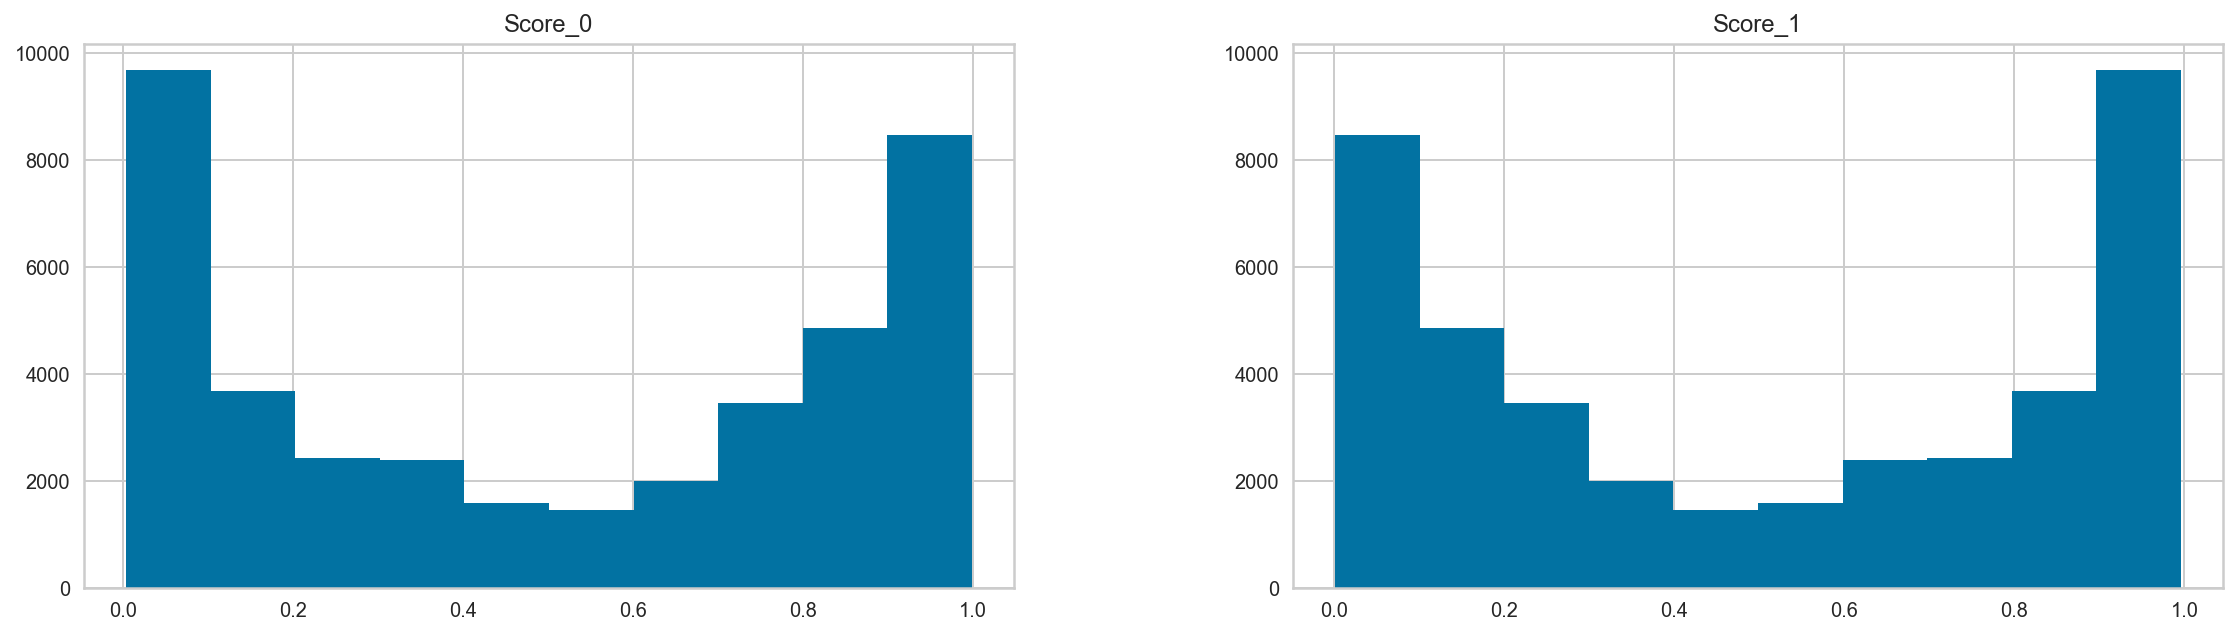

In [103]:
df_inference.hist(column=['Score_0', 'Score_1'], figsize=(30,5), layout=(1,3));

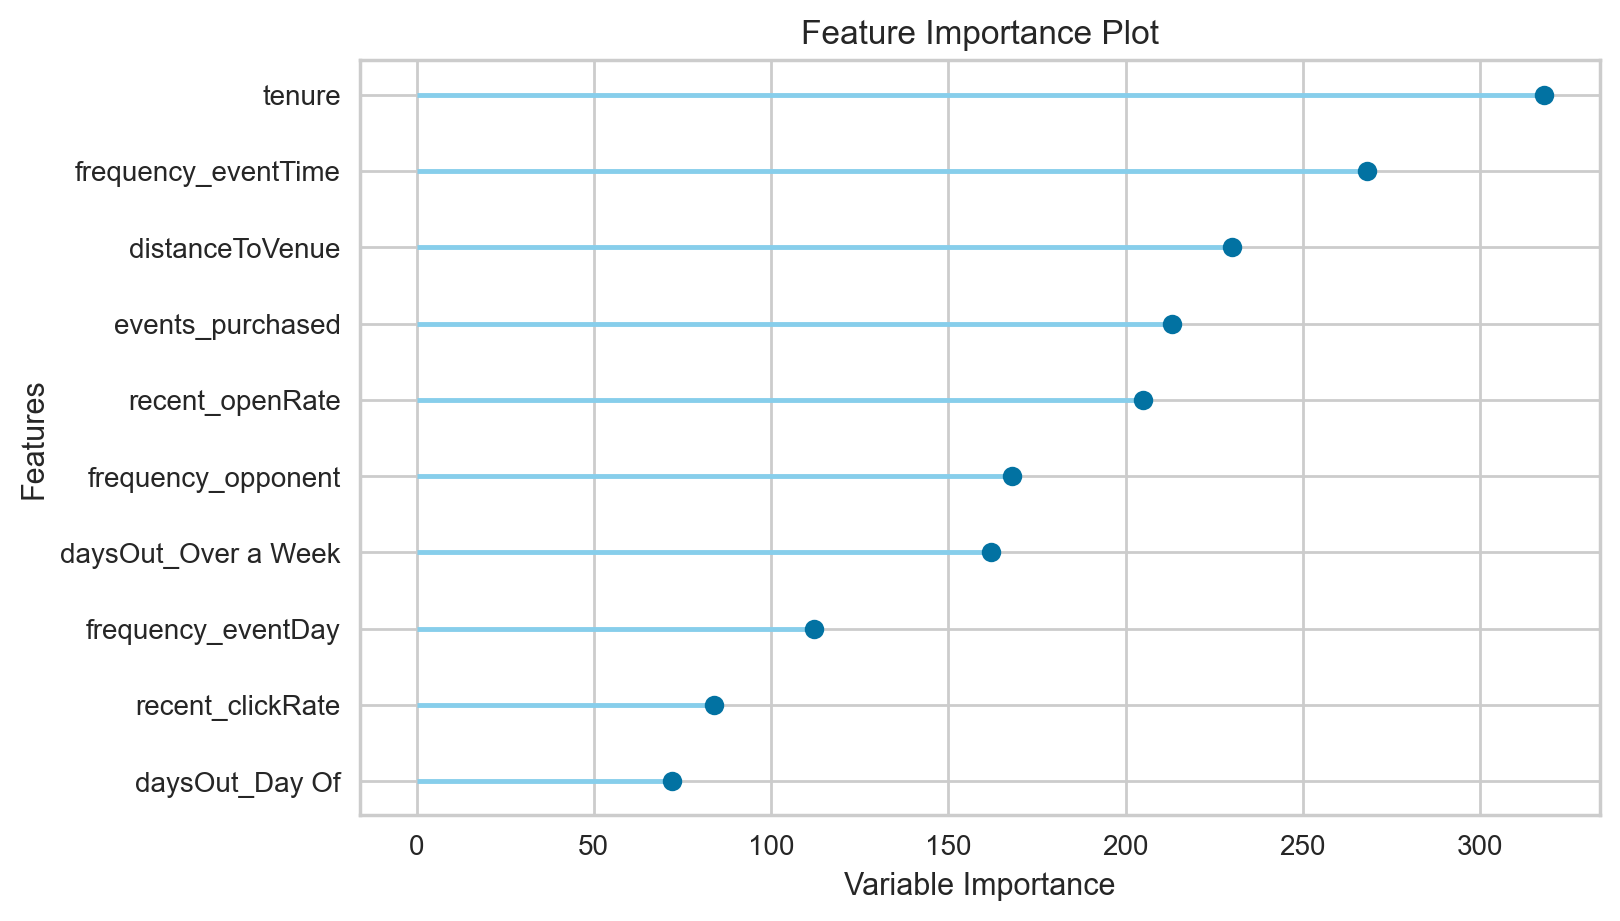

In [104]:
plot_model(best_model, plot='feature')

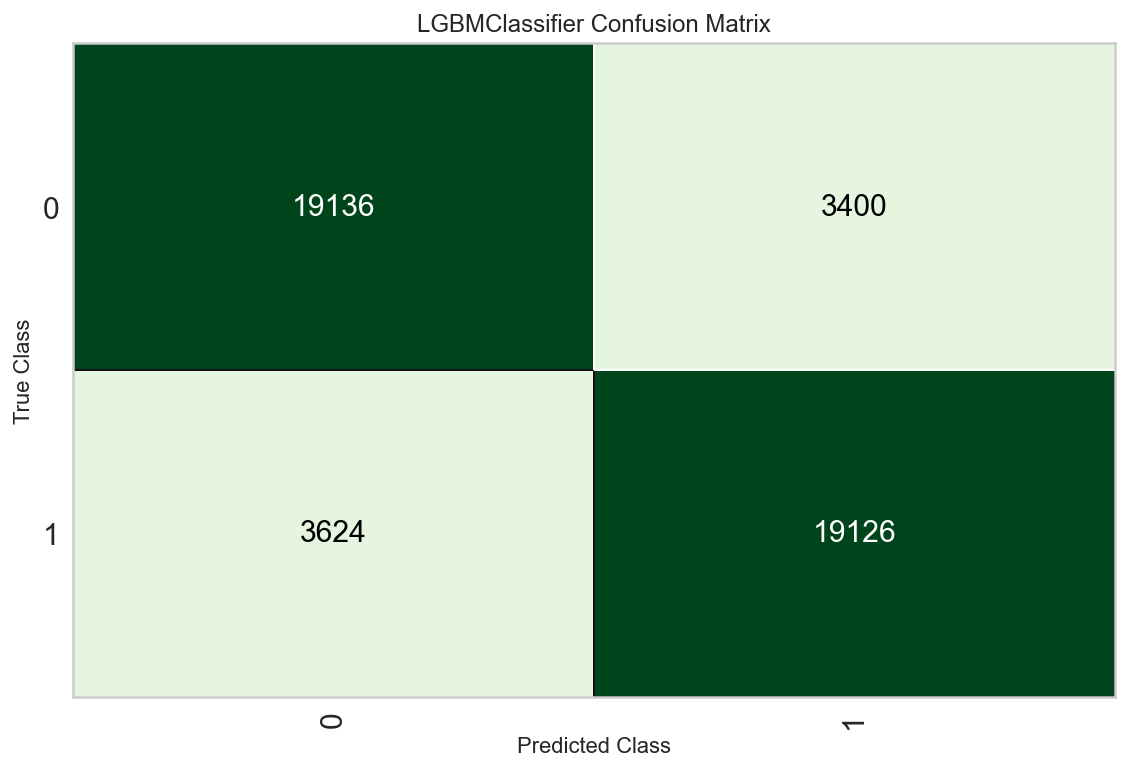

In [105]:
plot_model(best_model, plot='confusion_matrix')

## Observations
Here you can document some ideas on the results from above


## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?